In [1]:
import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import h5py
import time

import os
from dotenv import load_dotenv
load_dotenv()

from data_manipulation.reading_util import load_ml_data_emb
from data_manipulation.reading_util import load_non_enz_esm2


2023-10-03 23:02:33.590275: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-03 23:02:33.628922: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-03 23:02:33.629485: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-03 23:02:34.654584: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Check if a GPU is available and print information about it
if tf.test.gpu_device_name():
    print('GPU found')
    print('GPU device name:', tf.test.gpu_device_name())
else:
    print('No GPU found')

No GPU found


# Loading Embeddings and labeling

In [3]:
enzyme_csv_path = os.getenv("CSV30_ENZYMES")
esm2_enzymes_path = os.getenv("ESM2_ENZYMES_SPLIT_30")

non_enzymes_esm2_path = os.getenv("ESM2_NON_ENZYMES")
non_enzymes_fasta_path = os.getenv("FASTA_NON_ENZYMES")


# Load enzymes
X_enzymes, y_enzymes = load_ml_data_emb(path_to_esm2=esm2_enzymes_path, path_to_enzyme_csv=enzyme_csv_path)


# Load non_enzymes
X_non_enzymes, y_non_enzymes = load_non_enz_esm2(non_enzymes_fasta_path=non_enzymes_fasta_path,
                             non_enzymes_esm2_path=non_enzymes_esm2_path)




LOG: 3 Sequences with aa O in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG: 15 Sequences with aa U in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG: 203 multifunctional enzymes with diff ec main classes in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG: 221 entries will be ignored
LOG: Data loaded in: 1.044 min
LOG: ESM2 of enzymes: 9204
LOG: Labels of enzymes: 9204
LOG: 0 Sequences with aa O in /home/malte/Desktop/Dataset/data/non_enzyme/fasta/no_enzyme_train.fasta
LOG: 17 Sequences with aa U in /home/malte/Desktop/Dataset/data/non_enzyme/fasta/no_enzyme_train.fasta
LOG: 2138 non enzymes are longer than 1022 cutoff
LOG: 2155 entries will be ignored
LOG: Non Enzymes data loaded in: 4.411 min
LOG: ESM2 of non enzymes: 39502
LOG: Labels of non enzymes: 39502


In [4]:
X_non_enzymes = X_non_enzymes[:7000]
y_non_enzymes = y_non_enzymes[:7000]
print(y_non_enzymes[0])

7


## Append X_n and y_n to X and y:

In [5]:
X = np.vstack((X_enzymes, X_non_enzymes))
y = np.hstack((y_enzymes, y_non_enzymes))

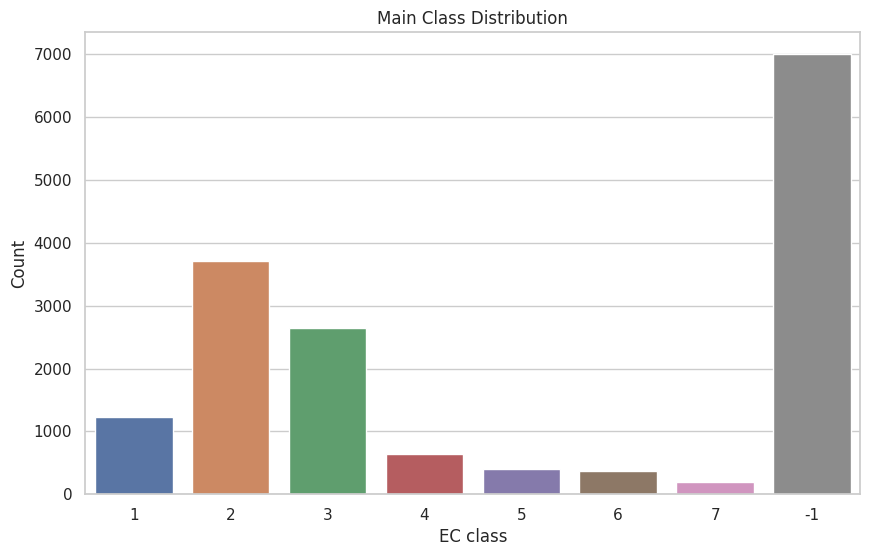

In [6]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.countplot(x=y)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], [1,2,3,4,5,6,7,-1])

# Add labels and title
plt.xlabel("EC class")
plt.ylabel("Count")
plt.title("Main Class Distribution")

# Show the plot
plt.show()


# Splitting data

In [7]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
# Our labels need to be one hot encoded
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=8)
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=8)
print(y_test_encoded[0])


[0. 0. 0. 0. 0. 0. 0. 1.]


# Creating CNN

In [9]:
# Initializing the model
model = tf.keras.models.Sequential()

earl_stop = tf.keras.callbacks.EarlyStopping(patience=5)

# Adding input layer
model.add(tf.keras.layers.Dense(units=256, activation='relu', input_shape=(2560,)))

# Adding hidden layer
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=64, activation='relu'))

# Finally adding output layer using softmax as activation function
model.add(tf.keras.layers.Dense(units=8, activation='softmax'))  # Using softmax for multi-class classification

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Training CNN

In [10]:
model.fit(x=X_train, y=y_train_encoded, epochs=7, validation_data=(X_test, y_test_encoded), callbacks = [earl_stop])

Epoch 1/7


2023-09-13 16:57:56.154595: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1893744640 exceeds 10% of free system memory.


5777/5780 [============================>.] - ETA: 0s - loss: 0.4534

2023-09-13 16:58:55.216305: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 811612160 exceeds 10% of free system memory.


5780/5780 [==============================] - 64s 11ms/step - loss: 0.4532 - val_loss: 0.1621
Epoch 2/7
5780/5780 [==============================] - 61s 11ms/step - loss: 0.2294 - val_loss: 0.1271
Epoch 3/7
5780/5780 [==============================] - 61s 11ms/step - loss: 0.1927 - val_loss: 0.1142
Epoch 4/7
5780/5780 [==============================] - 60s 10ms/step - loss: 0.1691 - val_loss: 0.1076
Epoch 5/7
5780/5780 [==============================] - 62s 11ms/step - loss: 0.1538 - val_loss: 0.0962
Epoch 6/7
5780/5780 [==============================] - 60s 10ms/step - loss: 0.1433 - val_loss: 0.0918
Epoch 7/7
5780/5780 [==============================] - 61s 11ms/step - loss: 0.1353 - val_loss: 0.0899


# Evaluation

<Figure size 1000x600 with 0 Axes>

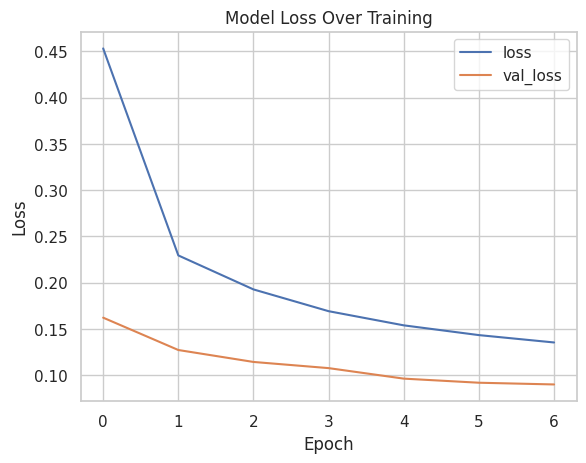

In [11]:
# Plotting loss (loss on train_data) and val_loss (loss on validation_data)
model_loss = pd.DataFrame(model.history.history)

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
model_loss.plot()

plt.title('Model Loss Over Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [12]:
# for multi class classification (using softmax)
predictions = np.argmax(model.predict(X_test), axis=-1) 

  23/2477 [..............................] - ETA: 5s  

2023-09-13 17:05:13.291492: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 811612160 exceeds 10% of free system memory.


2477/2477 [==============================] - 6s 2ms/step


In [13]:
counter = 0
for x,y in zip(y_test,predictions):
    if x == y:
        counter+=1
print("Correct predictions: ", counter)
print("Total samples predicted:", len(y_test))

Correct predictions:  77319
Total samples predicted: 79259


In [14]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      8311
           1       0.97      0.99      0.98     25021
           2       0.97      0.98      0.97     12490
           3       0.97      0.97      0.97      7011
           4       0.99      0.97      0.98      4332
           5       1.00      0.99      0.99      7789
           6       0.99      0.97      0.98      2426
           7       0.97      0.92      0.94     11879

    accuracy                           0.98     79259
   macro avg       0.98      0.97      0.98     79259
weighted avg       0.98      0.98      0.98     79259


In [4]:
def plot_report(report, y, predictions):
    """
    Plots results of model
    :param report: Report of model
    """

    class_0_metrics = report.split('\n')[2].split()[1:]
    class_1_metrics = report.split('\n')[3].split()[1:]
    class_2_metrics = report.split('\n')[4].split()[1:]
    class_3_metrics = report.split('\n')[5].split()[1:]
    class_4_metrics = report.split('\n')[6].split()[1:]
    class_5_metrics = report.split('\n')[7].split()[1:]
    class_6_metrics = report.split('\n')[8].split()[1:]
    class_7_metrics = report.split('\n')[9].split()[1:]

    metrics = [class_0_metrics,
               class_1_metrics,
               class_2_metrics,
               class_3_metrics,
               class_4_metrics,
               class_5_metrics,
               class_6_metrics,
               class_7_metrics
               ]

    precs = []
    recs = []
    f1_s = []

    for class_m in metrics:
        precision = float(class_m[0])
        recall = float(class_m[1])
        f1_score = float(class_m[2])
        precs.append(precision)
        recs.append(recall)
        f1_s.append(f1_score)

    class_names = [1, 2, 3, 4, 5, 6, 7, 0]

    # Create subplots for accuracy, precision, and F1
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Plot accuracy for each class
    ax1.bar(class_names, recs)
    ax1.set_title("Recall")
    ax1.set_xlabel("Main Class")


    # Plot precision for each class
    ax2.bar(class_names, precs)
    ax2.set_title("Precision")
    ax2.set_xlabel("Main Class")

    # Plot F1 score for each class
    ax3.bar(class_names, f1_s)
    ax3.set_title("F1 Score")
    ax3.set_xlabel("Main Class")

    # Adjust layout
    plt.tight_layout()

    # Show the plots
    plt.show()


    conf_matrix = confusion_matrix(y, predictions)

    # Create a confusion matrix heatmap
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.2)  # Adjust font size as needed
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

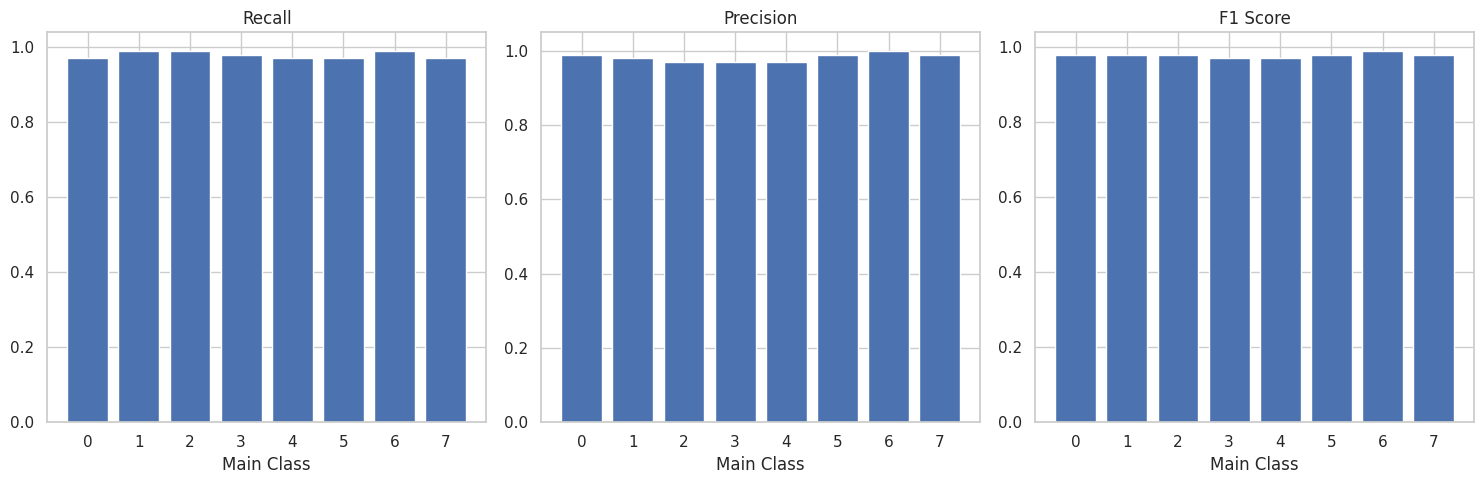

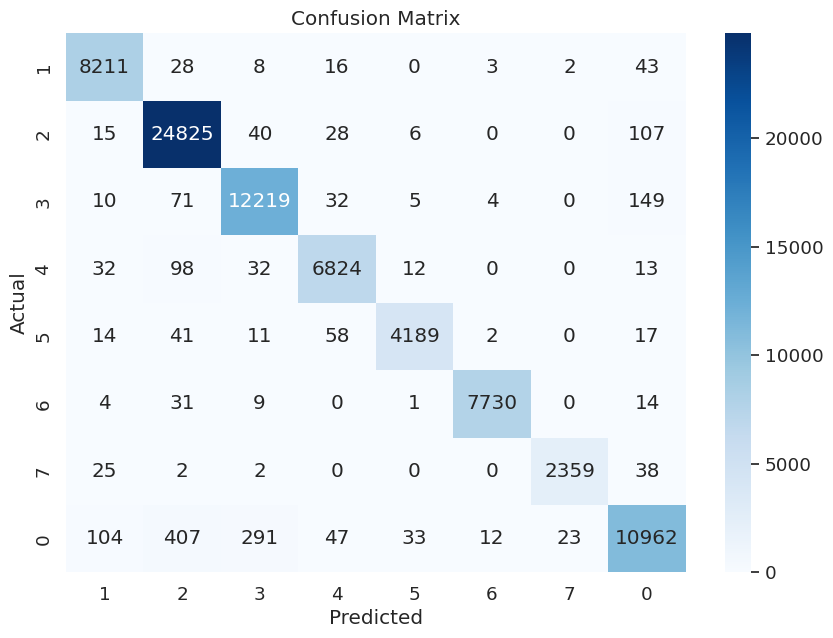

In [16]:
plot_report(report, y_test, predictions)

In [17]:
model.save("/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/enzyme_non_enzyme_models/cnn_v1_enz_non_enz_S100.keras")

# Testing Optuna for hyperparams

In [15]:
def objective(trial):
    # Define hyperparameters to be optimized
    num_units_dense_1 = trial.suggest_int('num_units_dense_1', 32, 512)
    dropout_rate_1 = trial.suggest_float('dropout_rate_1', 0.0, 0.7)
    num_units_dense_2 = trial.suggest_int('num_units_dense_2', 32, 256)
    dropout_rate_2 = trial.suggest_float('dropout_rate_2', 0.0, 0.7)
    num_units_dense_3 = trial.suggest_int('num_units_dense_3', 16, 128)
    
    # Create the model with the suggested hyperparameters
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=num_units_dense_1, activation='relu', input_shape=(2560,)))
    model.add(tf.keras.layers.Dropout(dropout_rate_1))
    model.add(tf.keras.layers.Dense(units=num_units_dense_2, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout_rate_2))
    model.add(tf.keras.layers.Dense(units=num_units_dense_3, activation='relu'))
    model.add(tf.keras.layers.Dense(units=8, activation='softmax'))
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Split your data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=8)
    y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes=8)
    
    # Define early stopping callback
    early_stop = tf.keras.callbacks.EarlyStopping(patience=10)
    
    # Train the model
    history = model.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded), epochs=25, callbacks=[early_stop], verbose=0)
    
    # Get the best validation loss
    val_loss = min(history.history['val_loss'])
    
    return val_loss

In [16]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)  # You can adjust the number of trials as needed

[I 2023-10-03 14:33:29,647] A new study created in memory with name: no-name-c72ff0be-c328-46e8-aacd-45e98e969d5e
[I 2023-10-03 14:34:04,276] Trial 0 finished with value: 0.5066938996315002 and parameters: {'num_units_dense_1': 86, 'dropout_rate_1': 0.13988114693386736, 'num_units_dense_2': 202, 'dropout_rate_2': 0.6975470166742198, 'num_units_dense_3': 16}. Best is trial 0 with value: 0.5066938996315002.
[I 2023-10-03 14:36:57,843] Trial 1 finished with value: 0.45714566111564636 and parameters: {'num_units_dense_1': 461, 'dropout_rate_1': 0.4792596814937752, 'num_units_dense_2': 52, 'dropout_rate_2': 0.3707863135987024, 'num_units_dense_3': 106}. Best is trial 1 with value: 0.45714566111564636.
[I 2023-10-03 14:38:17,764] Trial 2 finished with value: 0.4494343400001526 and parameters: {'num_units_dense_1': 201, 'dropout_rate_1': 0.5791009941050751, 'num_units_dense_2': 240, 'dropout_rate_2': 0.40301683300551705, 'num_units_dense_3': 91}. Best is trial 2 with value: 0.4494343400001526

KeyboardInterrupt: 

Trial 23 finished with value: 0.442497581243515 and parameters: {'num_units_dense_1': 435, 'dropout_rate_1': 0.6283712630836917, 'num_units_dense_2': 157, 'dropout_rate_2': 0.34594360535817104, 'num_units_dense_3': 107}. Best is trial 23 with value: 0.442497581243515.

In [8]:
best_num_units_dense_1 = 435
best_dropout_rate_1 = 0.6283712630836917
best_num_units_dense_2 = 157
best_dropout_rate_2 = 0.34594360535817104
best_num_units_dense_3 = 107


# best_params = study.best_params
# best_num_units_dense_1 = best_params['num_units_dense_1']
# best_dropout_rate_1 = best_params['dropout_rate_1']
# best_num_units_dense_2 = best_params['num_units_dense_2']
# best_dropout_rate_2 = best_params['dropout_rate_2']
# best_num_units_dense_3 = best_params['num_units_dense_3']

final_model = tf.keras.models.Sequential()
final_model.add(tf.keras.layers.Dense(units=best_num_units_dense_1, activation='relu', input_shape=(2560,)))
final_model.add(tf.keras.layers.Dropout(best_dropout_rate_1))
final_model.add(tf.keras.layers.Dense(units=best_num_units_dense_2, activation='relu'))
final_model.add(tf.keras.layers.Dropout(best_dropout_rate_2))
final_model.add(tf.keras.layers.Dense(units=best_num_units_dense_3, activation='relu'))
final_model.add(tf.keras.layers.Dense(units=8, activation='softmax'))
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=42)
# Our labels need to be one hot encoded
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=8)
y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes=8)

# Define early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(patience=40)

final_model.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded), epochs=100, callbacks=[early_stop], verbose=1)

Epoch 1/100
355/355 [==============================] - 7s 19ms/step - loss: 1.2492 - accuracy: 0.5399 - val_loss: 0.9462 - val_accuracy: 0.6855
Epoch 2/100
355/355 [==============================] - 7s 19ms/step - loss: 0.9401 - accuracy: 0.6779 - val_loss: 0.7928 - val_accuracy: 0.7478
Epoch 3/100
355/355 [==============================] - 7s 19ms/step - loss: 0.8183 - accuracy: 0.7274 - val_loss: 0.6879 - val_accuracy: 0.7775
Epoch 4/100
355/355 [==============================] - 7s 19ms/step - loss: 0.7396 - accuracy: 0.7575 - val_loss: 0.6775 - val_accuracy: 0.7842
Epoch 5/100
355/355 [==============================] - 7s 19ms/step - loss: 0.6876 - accuracy: 0.7752 - val_loss: 0.6550 - val_accuracy: 0.7980
Epoch 6/100
355/355 [==============================] - 7s 19ms/step - loss: 0.6499 - accuracy: 0.7834 - val_loss: 0.6029 - val_accuracy: 0.8110
Epoch 7/100
355/355 [==============================] - 7s 19ms/step - loss: 0.6219 - accuracy: 0.7964 - val_loss: 0.6120 - val_accuracy:

<Figure size 1000x600 with 0 Axes>

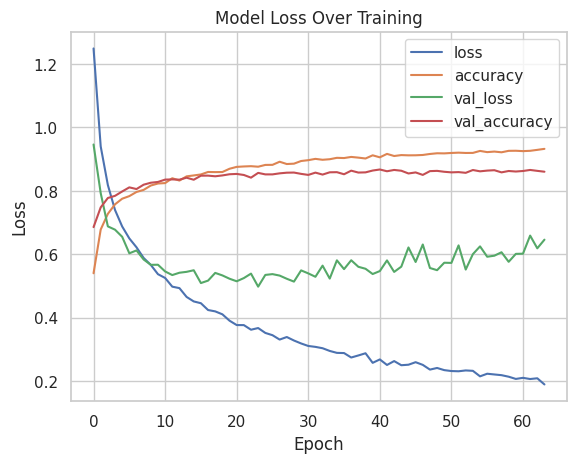

In [9]:
# Plotting loss (loss on train_data) and val_loss (loss on validation_data)
model_loss = pd.DataFrame(final_model.history.history)

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
model_loss.plot()

plt.title('Model Loss Over Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [10]:
predictions = np.argmax(final_model.predict(X_val), axis=-1)

counter = 0
for x,y in zip(y_val,predictions):
    if x == y:
        counter+=1
print("Correct predictions: ", counter)
print("Total samples predicted:", len(y_val))

152/152 [==============================] - 1s 3ms/step
Correct predictions:  4183
Total samples predicted: 4862


In [11]:
report = classification_report(y_val, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       369
           1       0.87      0.86      0.87      1132
           2       0.87      0.83      0.85       789
           3       0.53      0.64      0.58       189
           4       0.78      0.60      0.68       126
           5       0.91      0.82      0.87       114
           6       0.65      0.58      0.61        57
           7       0.91      0.92      0.91      2086

    accuracy                           0.86      4862
   macro avg       0.79      0.76      0.77      4862
weighted avg       0.86      0.86      0.86      4862


In [12]:
plot_report(report, y_val, predictions)

NameError: name 'plot_report' is not defined

In [15]:
final_model.save("/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/enzyme_non_enzyme_models/cnn_S30_opt_v1.keras")
